# Demo that model fails in extrapolation range


## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-06-20 12:53:31.543882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 12:53:32.101909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-20 12:53:33.082529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 12:53:33.100179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Load trained forward model and data scaler

Here we load the pre-trained model and the data scaler

In [2]:
data_path = 'datasets/dataset1_random.h5'
model_path = 'models/fwd_model_resnet.h5'

# load data scalers
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

# load pretrained forward model
fwd_model = keras.models.load_model(model_path)

2023-06-20 12:53:34.075381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 12:53:34.075578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 12:53:34.075699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## generate interpolation and extrapolation samples

In [3]:
rng = np.random.default_rng()

N_samples = 4
wavelengths = np.linspace(500, 1500, 64)
N_layers = 5


# interpolation regime: parameter ranges
thickness_limits = [20, 180]   # thickness limits (in nm)
eps_limits = [1.3**2, 2.5**2]  # permittivity limits

_mat_list = []
_thick_list = []
R_list_interpolate = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]

    R_list_interpolate.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_interpolate = helper.scale_and_concatenate_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)


# extrapolation regime 1: larger parameter values
thickness_limits = [180, 200]  # thickness limits (in nm)
eps_limits = [2.5**2, 3**2]    # permittivity limits

_mat_list = []
_thick_list = []
R_list_extrapolate1 = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    
    R_list_extrapolate1.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_extrapolate1 = helper.scale_and_concatenate_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)


# extrapolation regime 2: smaller parameter values
thickness_limits = [10, 20]  # thickness limits (in nm)
eps_limits = [1.1**2, 1.3**2]    # permittivity limits

_mat_list = []
_thick_list = []
R_list_extrapolate2 = []
for i in tqdm(range(N_samples)):
    # random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * \
        np.diff(thickness_limits) + thickness_limits[0]
    materials = rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    
    R_list_extrapolate2.append(helper.calc_R(thicknesses, materials, wavelengths))
    _mat_list.append(materials)
    _thick_list.append(thicknesses)

geo_extrapolate2 = helper.scale_and_concatenate_Rspec_data(
    _mat_list, _thick_list, scaler_mat, scaler_thick)

100%|██████████| 4/4 [00:00<00:00, 105.20it/s]


2023-06-20 12:53:36.628548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-20 12:53:37.391037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<function matplotlib.pyplot.show(close=None, block=None)>

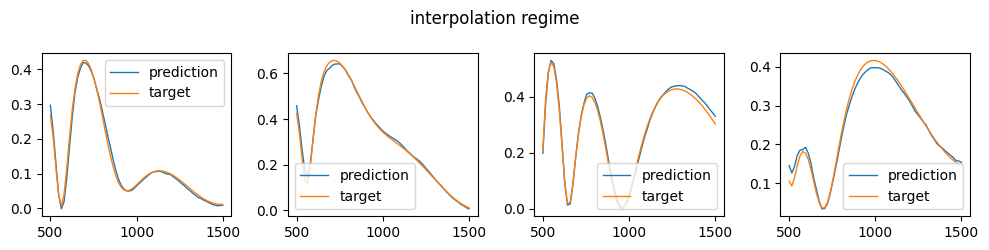

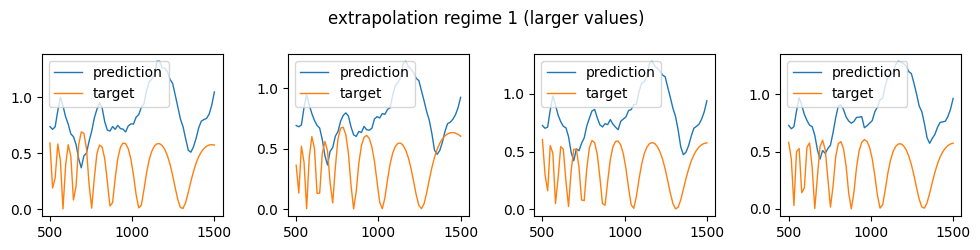

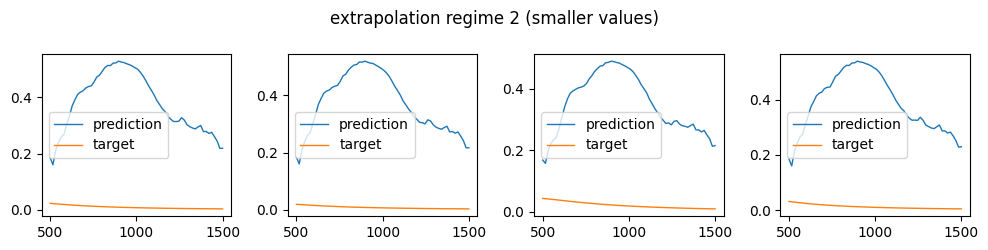

In [4]:
# plot interpolation samples
pred_inter = fwd_model.predict(geo_interpolate, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("interpolation regime")
for i in range(len(geo_interpolate)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_inter[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_interpolate[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show


# plot extrapolation samples - part 1/1
pred_extra1 = fwd_model.predict(geo_extrapolate1, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("extrapolation regime 1 (larger values)")
for i in range(len(geo_extrapolate1)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_extra1[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_extrapolate1[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show


# plot extrapolation samples - part 2/2
pred_extra2 = fwd_model.predict(geo_extrapolate2, verbose=0)

plt.figure(figsize=(10, 2.5))
plt.suptitle("extrapolation regime 2 (smaller values)")
for i in range(len(geo_extrapolate2)):
    plt.subplot(1, 4, i+1)
    plt.plot(wavelengths, pred_extra2[i], label='prediction', linewidth=1)
    plt.plot(wavelengths, R_list_extrapolate2[i], label='target', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show